### 모듈 불러오기

In [1]:
import warnings             
warnings.filterwarnings(action='ignore')          # 경고 문구 무시
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"   # 셀 하나에 ouput 모두 출력 가능
import numpy as np                            
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#  한글글꼴로 변경
plt.rcParams['font.size'] = 12.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rc('axes', unicode_minus = False)

# plot 크기
plt.rc('figure', figsize=(10,6))

# 음수 표시 에러 
mpl.rcParams['axes.unicode_minus'] = False
import json
pd.options.display.max_rows= 10    # 화면에 최대 12개까지 결과 출력
np.random.seed(0)

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import os
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [2]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from PIL import Image

In [63]:
keras.models.load_model('model/best-cnn-model.h5')

In [64]:
keras.__version__

'2.5.0'

In [65]:
def set_env():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.per_process_gpu_memory_fraction = 0.75
    session = tf.compat.v1.Session(config=config)
    session
set_env()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5



### ImgaeDataenertator
컨볼루션 신경망 모델을 위한 데이터 부풀리기 클래스
+ 학습 도중에 이미지에 임의 변형 및 정규화 적용
+ 변형된 이미지를 배치 단위로 불러올 수 있는 generator 생성.
    + generator를 생성할 때 flow(data, labels), flow_from_directory(directory) 두 가지 함수를 사용합니다.
    + fit_generator, evaluate_generator 함수를 이용하여 generator로 이미지를 불러와서 모델을 학습시킬 수 있습니

#### 파라미터(기본값)
<code style="display:block">
+keras.preprocessing.image.ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=0.,
width_shift_range=0.,
height_shift_range=0.,
shear_range=0.,
zoom_range=0.,
channel_shift_range=0.,
fill_mode='nearest',
cval=0.,
horizontal_flip=False,
vertical_flip=False,
rescale=None,
preprocessing_function=None,
data_format=K.image_data_format())
</code>


+ shear_range : 범위 내에서 임의로 원본 이미지 변형(0.5면 0~0.5각도로 )
+ zoom_range : 지정된 범위내로 임의로 원본이미지 확대/축소 0.3 이면 -0.3~0.3 범위 로 확대축소
+ rotation_range : 지정된 각도 범위내로 임의로 원본 이미지 회전(90이면 0~90 다함)
+ width_shift_range : 지정된 수평방향 이동 범위로 원본 이미지 이동 : 0.1이면 넓이 100에서 0~10px 좌우 이동
+ height_shift_range :수직방향
+ vertical_flip : 수직방향 뒤집기 (boolean)
+ horizontal_flip 수평방향 뒤집기 True일경우 50% 확률로 이미지를 수평으로 뒤집
+ fill_mode 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식

데이터 경로

In [4]:
train_path = os.getcwd() + '\\datas\\train'
test_path = os.getcwd() + '\\datas\\test'
valid_path = os.getcwd() + '\\datas\\val'

### 이미지 유효성 검사

In [5]:
import cv2
import os
import numpy as np

label_counts = {}
idx = ['train', 'test', 'valid']
def get_train_data(): 
    data_input = []
    error_paths = []
    for i, path in enumerate([train_path, test_path, valid_path]):
        label_dirs = os.listdir(path)
        for dir_name in label_dirs:
            file_list = os.listdir(f'{path}\\{dir_name}')
            label_counts[f'{idx[i]}_{dir_name}'] = len(file_list)
            for file_name in file_list:
                try:
#                     print(file_name)
                    img = Image.open(f'{path}\\{dir_name}\\{file_name}')
                    im = img.load()

                except Exception as e:
                        err_string = f'[Error!] at {path}\\{dir_name}\\{file_name}'
                        error_paths.append(err_string)
                        print(err_string)
                        print(e)
                        continue


get_train_data()

In [6]:
label_counts

{'train_cockroach': 4356,
 'train_etc': 3425,
 'train_spider': 7908,
 'test_cockroach': 1074,
 'test_etc': 3864,
 'test_spider': 2006,
 'valid_cockroach': 1064,
 'valid_etc': 3924,
 'valid_spider': 1966}

### 데이터 전처리

검증 및 테스트 이미지는 augmentation을 적용하지 않습니다. 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.

In [7]:
train_dataGen = ImageDataGenerator(
                       rescale=1/255,              # scale
                       fill_mode='nearest',        # 변형시 공간 채우는방식
                       rotation_range=40,         # 회전
                       shear_range=.2,           # 전단 변환
                       vertical_flip=True,      # 수직 뒤집기
                       horizontal_flip=True,    # 수평 뒤집기
                       height_shift_range=.2,    # 이미지 수직 이동
                       width_shift_range=.2,    # 수평 이동
                       zoom_range=.2,          # -0.2~0.2 확대 축소
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#### 데이터 디버깅

In [7]:
datagen = ImageDataGenerator(
                       fill_mode='nearest',        # 변형시 공간 채우는방식
                       rotation_range=40,         # 회전
                       shear_range=.2,           # 전단 변환
                       vertical_flip=True,      # 수직 뒤집기
                       horizontal_flip=True,    # 수평 뒤집기
                       height_shift_range=.2,    # 이미지 수직 이동
                       width_shift_range=.2,    # 수평 이동
                       zoom_range=.2,          # -0.2~0.2 확대 축소
)         

img = load_img('C:/project/phobiaFilter/dataset/train/cockroach_many/cockr534.jpg')  # PIL 이미지
img2 = load_img('C:/project/phobiaFilter/dataset/train/cockroach_many/cockroache-1569.jpg')  # PIL 이미지

x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
x = x.reshape((1,) + x.shape)  
x2 = img_to_array(img2)  # (3, 150, 150) 크기의 NumPy 배열
x2 = x2.reshape((1,) + x2.shape)  

# 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# 지정된 `preview/` 폴더에 저장합니다.
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='C:\project\phobiaFilter\dataset\preview', save_prefix='cocks', save_format='jpeg'):
    i += 1
    if i > 40:
        break  # 이미지 20장을 생성하고 마칩니다

i=0
for batch in datagen.flow(x2, batch_size=1,
                  save_to_dir='C:\project\phobiaFilter\dataset\preview', save_prefix='cocks2', save_format='jpeg'):
    i += 1
    if i > 40:
        break  # 이미지 20장을 생성하고 마칩니다

#### Data 생성

In [102]:
batch_size = 16
train_generator = train_dataGen.flow_from_directory(train_path, target_size=(150,150), batch_size=batch_size, class_mode='categorical')
test_generator = valid_datagen.flow_from_directory(test_path, target_size=(150,150), batch_size=batch_size, class_mode='categorical')
valid_generator = test_datagen.flow_from_directory(valid_path, target_size=(150,150), batch_size=batch_size, class_mode='categorical')
train_generator
test_generator
valid_generator

Found 15689 images belonging to 3 classes.
Found 6940 images belonging to 3 classes.
Found 6946 images belonging to 3 classes.


In [103]:
train_generator.class_indices
len(train_generator.class_indices)

{'cockroach': 0, 'etc': 1, 'spider': 2}

3

엔트로피 용량을 조절하는 방법은 다양합니다. 대표적으로 모델에 관여하는 파라미터 개수를 조절하는 방법이 있습니다. 레이어 개수와 레이어 크기가 여기에 해당하죠. 저희가 작은 규모의 CNN을 사용하는 이유가 여기에 있습니다. 또한, L1, L2 정규화 (regularization) 같은 가중치 정규화 기법이 있습니다. 학습하면서 모든 가중치를 반복적으로 축소하는 방법인데, 결과적으로 핵심적인 특징에 대한 가중치만 남게 되는 효과가 있습니다.

### 모델 생성

In [43]:

# model = keras.Sequential()
# # 필터 층 추가 
# # same 패딩을 적용했기 때문에 특성맵과 입력의 크기가 동일
# model.add(keras.layers.Conv2D(32, kernel_size=10, activation='relu',
#                               padding='same', input_shape=(150,150,1)))

# model.add(keras.layers.MaxPooling2D(2))
# model.add(keras.layers.Conv2D(64, kernel_size=10, activation='relu', padding='same'))
# model.add(keras.layers.MaxPooling2D(2))
# model.add(keras.layers.Flatten())    # 출력층 입력을 위해 1차원 변환
# model.add(keras.layers.Dense(200, activation='relu'))
# model.add(keras.layers.Dropout(0.4))            # 과대적합 방지 
# model.add(keras.layers.Dense(3, activation='softmax'))
# model.summary()
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# checkpoint_cb = keras.callbacks.ModelCheckpoint('model/best-cnn-model.h5')
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# history = model.fit(train_scaled, train_target, epochs=20, validation_data=(valid_scaled, valid_target),
#                     callbacks=[checkpoint_cb, early_stopping_cb])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train', 'val'])
# plt.show();


# model.evaluate(valid_scaled, valid_target)
# model.evaluate(test_scaled, test_target)


### 정확도와 손실율 확인하기

In [44]:

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'go', label='Training Loss')
# plt.plot(epochs, val_loss, 'g', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

### 첫 번째 모델
+ 훈련셋 : 정확도 50%
+ 검증셋 : 정확도 30% 

In [46]:
model=Sequential()
model.add(Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2))

model.add(Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2))

model.add(Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

model.fit_generator(
        train_generator,
        validation_data=valid_generator,
#         validation_steps=50,
    #verbose=2
        epochs=40)
model.save_weights('model/first_model.h5')  # 많은 시간을 들여 학습한 모델인 만큼, 학습 후에는 꼭 모델을 저장해줍시다.


Epoch 1/40
981/981 [==============================] - 197s 198ms/step - loss: 1.0609 - accuracy: 0.4835 - val_loss: 1.2306 - val_accuracy: 0.2819
Epoch 2/40
981/981 [==============================] - 198s 201ms/step - loss: 1.0386 - accuracy: 0.4996 - val_loss: 1.2419 - val_accuracy: 0.2819
Epoch 3/40
981/981 [==============================] - 190s 194ms/step - loss: 1.0380 - accuracy: 0.5023 - val_loss: 1.2575 - val_accuracy: 0.2819
Epoch 4/40
981/981 [==============================] - 194s 197ms/step - loss: 1.0339 - accuracy: 0.5040 - val_loss: 1.2438 - val_accuracy: 0.2819
Epoch 5/40
981/981 [==============================] - 196s 199ms/step - loss: 1.0300 - accuracy: 0.5094 - val_loss: 1.2486 - val_accuracy: 0.2819
Epoch 6/40
981/981 [==============================] - 195s 199ms/step - loss: 1.0385 - accuracy: 0.4976 - val_loss: 1.2358 - val_accuracy: 0.2819
Epoch 7/40
981/981 [==============================] - 202s 206ms/step - loss: 1.0408 - accuracy: 0.4950 - val_loss: 1.2590 -

KeyboardInterrupt: 

### 두번째 모델

In [3]:
from keras import applications

In [4]:
vgg_model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [8]:
batch_size = 16
train_generator = train_dataGen.flow_from_directory(train_path, target_size=(150,150), batch_size=batch_size, class_mode=None, shuffle=False)
test_generator = valid_datagen.flow_from_directory(test_path, target_size=(150,150), batch_size=batch_size, class_mode=None, shuffle=False)
valid_generator = test_datagen.flow_from_directory(valid_path, target_size=(150,150), batch_size=batch_size, class_mode=None, shuffle=False)
train_generator
test_generator
valid_generator

Found 15689 images belonging to 3 classes.
Found 6940 images belonging to 3 classes.
Found 6946 images belonging to 3 classes.


In [10]:
bottleneck_features_train = vgg_model.predict_generator(train_generator, train_generator.samples//batch_size)
np.save(open('model/bottleneck_features_train2.npy', 'wb'), bottleneck_features_train)

In [14]:
bottleneck_features_valid = vgg_model.predict_generator(valid_generator, valid_generator.samples//batch_size)
np.save(open('model/bottleneck_features_valid2.npy', 'wb'), bottleneck_features_valid)

In [14]:
train_data = np.load(open('model/bottleneck_features_train.npy', 'rb'))
valid_data = np.load(open('model/bottleneck_features_valid.npy', 'rb'))
valid_data

array([[[[2.9638262 , 0.        , 0.        , ..., 0.        ,
          0.5799281 , 0.        ],
         [3.1682796 , 0.        , 0.        , ..., 0.        ,
          0.56045103, 0.        ],
         [1.3320899 , 0.        , 0.14621115, ..., 0.        ,
          0.82582194, 0.        ],
         [1.4184277 , 0.        , 0.2643201 , ..., 0.        ,
          0.7630368 , 0.        ]],

        [[2.7745922 , 0.        , 0.        , ..., 0.        ,
          0.67750555, 0.        ],
         [2.8662744 , 0.        , 0.26052243, ..., 0.        ,
          0.33991322, 0.        ],
         [1.3859388 , 0.        , 1.2953296 , ..., 0.        ,
          0.8689036 , 0.        ],
         [0.83747655, 0.        , 1.3656135 , ..., 0.        ,
          0.98654073, 0.        ]],

        [[0.82537097, 0.        , 0.15404952, ..., 0.        ,
          0.7168837 , 0.        ],
         [1.4893606 , 0.        , 0.27200404, ..., 0.        ,
          0.37301528, 0.        ],
         [1.1949

In [15]:
label_counts
list(label_counts.values())
list(label_counts.keys())

{'train_cockroach': 4356,
 'train_etc': 3425,
 'train_spider': 7908,
 'test_cockroach': 1074,
 'test_etc': 3864,
 'test_spider': 2006,
 'valid_cockroach': 1064,
 'valid_etc': 3924,
 'valid_spider': 1966}

[4356, 3425, 7908, 1074, 3864, 2006, 1064, 3924, 1966]

['train_cockroach',
 'train_etc',
 'train_spider',
 'test_cockroach',
 'test_etc',
 'test_spider',
 'valid_cockroach',
 'valid_etc',
 'valid_spider']

In [16]:
train_labels = np.array([0] * label_counts['train_cockroach'] +
                       [1] * label_counts['train_etc'] +
                       [2] * (label_counts['train_spider']-9))
valid_labels = np.array([0] * (label_counts['valid_cockroach']//3) +
                       [1] * (label_counts['valid_etc']//3 )+
                       [2] * (label_counts['valid_spider']//3-13))
train_data.shape
train_labels.shape
valid_data.shape
valid_labels.shape

(15680, 4, 4, 512)

(15680,)

(2304, 4, 4, 512)

(2304,)

In [17]:
train_labels = to_categorical(train_labels, 3)
valid_labels = to_categorical(valid_labels, 3)

In [18]:
vgg_model = Sequential()
vgg_model.add(Flatten(input_shape=train_data.shape[1:]))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(64, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(3, activation='softmax'))

In [21]:
vgg_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('model/best-cnn-model.h5')
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = vgg_model.fit(train_data, train_labels,
          batch_size=batch_size,
          epochs=100,
          validation_data=(valid_data, valid_labels),
         callbacks=[checkpoint_cb])
vgg_model.save_weights('model/second_model.h5')

Epoch 1/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0415 - accuracy: 0.5030 - val_loss: 1.2005 - val_accuracy: 0.2786
Epoch 2/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0355 - accuracy: 0.5038 - val_loss: 1.2326 - val_accuracy: 0.2786
Epoch 3/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0339 - accuracy: 0.5038 - val_loss: 1.2394 - val_accuracy: 0.2786
Epoch 4/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0340 - accuracy: 0.5038 - val_loss: 1.2445 - val_accuracy: 0.2786
Epoch 5/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0334 - accuracy: 0.5038 - val_loss: 1.2578 - val_accuracy: 0.2786
Epoch 6/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0338 - accuracy: 0.5038 - val_loss: 1.2365 - val_accuracy: 0.2786
Epoch 7/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0339 - accuracy: 0.5036 - val_loss: 1.2452 - val_accuracy: 0.2786

980/980 [==============================] - 3s 3ms/step - loss: 1.0324 - accuracy: 0.5042 - val_loss: 1.2908 - val_accuracy: 0.2786
Epoch 58/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0316 - accuracy: 0.5041 - val_loss: 1.2727 - val_accuracy: 0.2786
Epoch 59/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0327 - accuracy: 0.5041 - val_loss: 1.2954 - val_accuracy: 0.2786
Epoch 60/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0312 - accuracy: 0.5041 - val_loss: 1.2745 - val_accuracy: 0.2786
Epoch 61/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0313 - accuracy: 0.5040 - val_loss: 1.2859 - val_accuracy: 0.2786
Epoch 62/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0316 - accuracy: 0.5040 - val_loss: 1.2844 - val_accuracy: 0.2786
Epoch 63/100
980/980 [==============================] - 3s 3ms/step - loss: 1.0313 - accuracy: 0.5041 - val_loss: 1.2898 - val_accuracy: 0.2786
Epoch

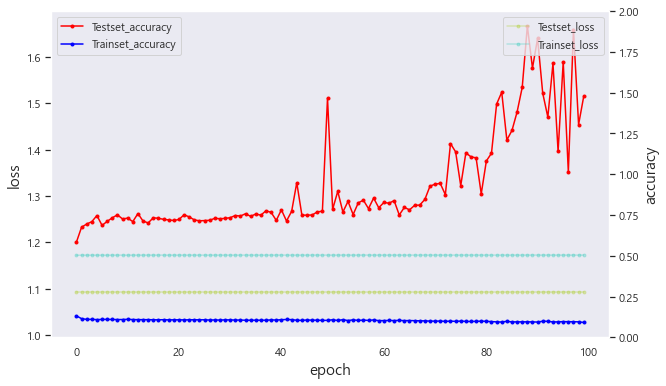

In [62]:
fig, ax1 = plt.subplots()

# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']
# 테스트 셋의 정답률
y_vaccuracy = history.history['val_accuracy']
# 학습셋의 정답률
y_accuracy = history.history['accuracy']

# 그래프로 표현
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker='.', c="red", label='Testset_accuracy')
ax1.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_accuracy')

ax2 = ax1.twinx()
# 그래프로 표현
x_len = np.arange(len(y_loss))
ax2.plot(x_len, y_vaccuracy, marker='.', c="#aacc22", label='Testset_loss', alpha=0.3)
ax2.plot(x_len, y_accuracy, marker='.', c="#33ccbb", label='Trainset_loss', alpha=0.3)

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('loss', fontsize=15)
ax2.set_ylabel('accuracy', fontsize=15)
plt.ylim(0, 2)
ax1.grid()
ax2.grid()
plt.savefig('figure/second_model_rate.png')
plt.show();


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

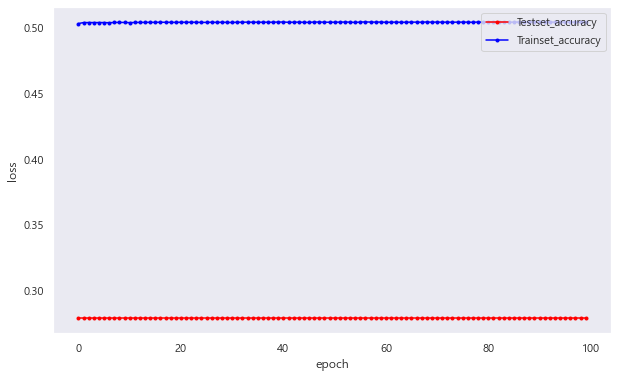

In [25]:


# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

### 세 번째 모델

In [59]:
vgg_model2 = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [54]:
for layer in vgg_model2.layers[:-10]:
    layer.trainable = False
for layer in vgg_model2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000252A2F01E80> False
<keras.layers.convolutional.Conv2D object at 0x00000252A30DFAC0> False
<keras.layers.convolutional.Conv2D object at 0x000002530F5BA280> False
<keras.layers.pooling.MaxPooling2D object at 0x00000252A30DF220> False
<keras.layers.convolutional.Conv2D object at 0x00000252A305E400> False
<keras.layers.convolutional.Conv2D object at 0x0000025318E45FA0> False
<keras.layers.pooling.MaxPooling2D object at 0x00000252A2F01AC0> False
<keras.layers.convolutional.Conv2D object at 0x000002530F5BA2B0> False
<keras.layers.convolutional.Conv2D object at 0x000002530F5BA3D0> False
<keras.layers.convolutional.Conv2D object at 0x0000025318E82940> True
<keras.layers.pooling.MaxPooling2D object at 0x000002530FAD34F0> True
<keras.layers.convolutional.Conv2D object at 0x00000253008053A0> True
<keras.layers.convolutional.Conv2D object at 0x00000252A2F240A0> True
<keras.layers.convolutional.Conv2D object at 0x000002530F773970> True
<keras.la

In [60]:
vgg_model2.output_shape
train_data.shape

(None, 4, 4, 512)

(15680, 4, 4, 512)

In [61]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_model2.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(32, activation='relu'))
top_model.add(Dropout(0.4))
vgg_model.add(Dense(3, activation='softmax'))
top_model.load_weights('model/second_model.h5')

ValueError: Cannot assign to variable dense_48/kernel:0 due to variable shape (64, 32) and value shape (64, 3) are incompatible

In [ ]:
new_model = Sequential()
for l in vgg_model2.layers:
    new_model.add(l)
for l in vgg_model2.layers:
    new_model.add(l)
    

    

### 네 번째 모델

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.datasets import imdb
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop


In [ ]:
x_train = train_generatororrat
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')/255
x_test= x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')/255

In [ ]:
autoencoder = Sequential()
# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D())
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D())
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

In [ ]:
# 디코딩 부분이 이어집니다. 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))



In [ ]:
autoencoder.summary()

### 성능 테스트

In [11]:
train_dataGen = ImageDataGenerator(
                       rescale=1/255,              # scale
                       fill_mode='nearest',        # 변형시 공간 채우는방식
                       rotation_range=40,         # 회전
                       shear_range=.2,           # 전단 변환
                       vertical_flip=True,      # 수직 뒤집기
                       horizontal_flip=True,    # 수평 뒤집기
                       height_shift_range=.2,    # 이미지 수직 이동
                       width_shift_range=.2,    # 수평 이동
                       zoom_range=.2,          # -0.2~0.2 확대 축소
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
batch_size = 16
train_generator = train_dataGen.flow_from_directory(train_path, target_size=(150,150), batch_size=batch_size, class_mode=None, shuffle=False)
test_generator = valid_datagen.flow_from_directory(test_path, target_size=(150,150), batch_size=batch_size, class_mode=None, shuffle=False)
valid_generator = test_datagen.flow_from_directory(valid_path, target_size=(150,150), batch_size=batch_size, class_mode=None, shuffle=False)
train_generator
test_generator
valid_generator

Found 15689 images belonging to 3 classes.
Found 6940 images belonging to 3 classes.
Found 6946 images belonging to 3 classes.


In [13]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.load_weightsa('model/second_model.h5')

NameError: name 'train_data' is not defined

In [ ]:
CLASS_NAMES = ['cockroach', 'etc', 'spider']
PATH = t

fig = plt.figure(figsize=(10,10))

for file in os.listdir(PATH):
    image = Image.open(PATH + file)
    size = (24, 24)
    image_array = img_to_array(image)
    # display the resized image
    
    plt.imshow(image);
    plt.xlabel()
    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 255) 
    
    idx = np.argmax(np.round(model.fit(normalized_image_array), 3))
    print(SHAPE[idx])


### 시각화

In [3]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf